impo        

In [1]:
import os
import sys
import pandas as pd
import numpy as np

# Visualize charging demand statistics
import matplotlib.pyplot as plt

In [2]:


# Load Melbourne data directly from CSV
print("Loading Melbourne (MEL) charging data...")
data_dir = "data/MEL_remove_zero/"

# Load volume data
volume_df = pd.read_csv(f"{data_dir}volume.csv", index_col=0)
sites_df = pd.read_csv(f"{data_dir}sites.csv", index_col=0)

print(f"\n✓ Successfully loaded Melbourne dataset!")
print(f"  - Number of charging sites: {volume_df.shape[1]}")
print(f"  - Time periods (hours): {volume_df.shape[0]}")
print(f"  - Date range: {volume_df.index[0]} to {volume_df.index[-1]}")
print(f"\nSample data (first 5 hours, first 3 sites):")
print(volume_df.iloc[:5, :3])
print(f"\nBasic statistics:")
print(f"  - Total sites in info: {len(sites_df)}")
print(f"  - Average volume per hour per site: {volume_df.values.mean():.2f} kWh")
print(f"  - Max volume in dataset: {volume_df.values.max():.2f} kWh")

Loading Melbourne (MEL) charging data...

✓ Successfully loaded Melbourne dataset!
  - Number of charging sites: 62
  - Time periods (hours): 4392
  - Date range: 2023-04-01 00:00:00 to 2023-09-30 23:00:00

Sample data (first 5 hours, first 3 sites):
                       0    1         10
2023-04-01 00:00:00  0.0  0.0   0.000000
2023-04-01 01:00:00  0.0  0.0   0.000000
2023-04-01 02:00:00  0.0  0.0   0.000000
2023-04-01 03:00:00  0.0  0.0   3.666667
2023-04-01 04:00:00  0.0  0.0  44.000000

Basic statistics:
  - Total sites in info: 62
  - Average volume per hour per site: 47.94 kWh
  - Max volume in dataset: 5191.67 kWh


/tmp/ipykernel_291998/504064040.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_yticklabels([f'Site {i}' for i in top_5_sites])


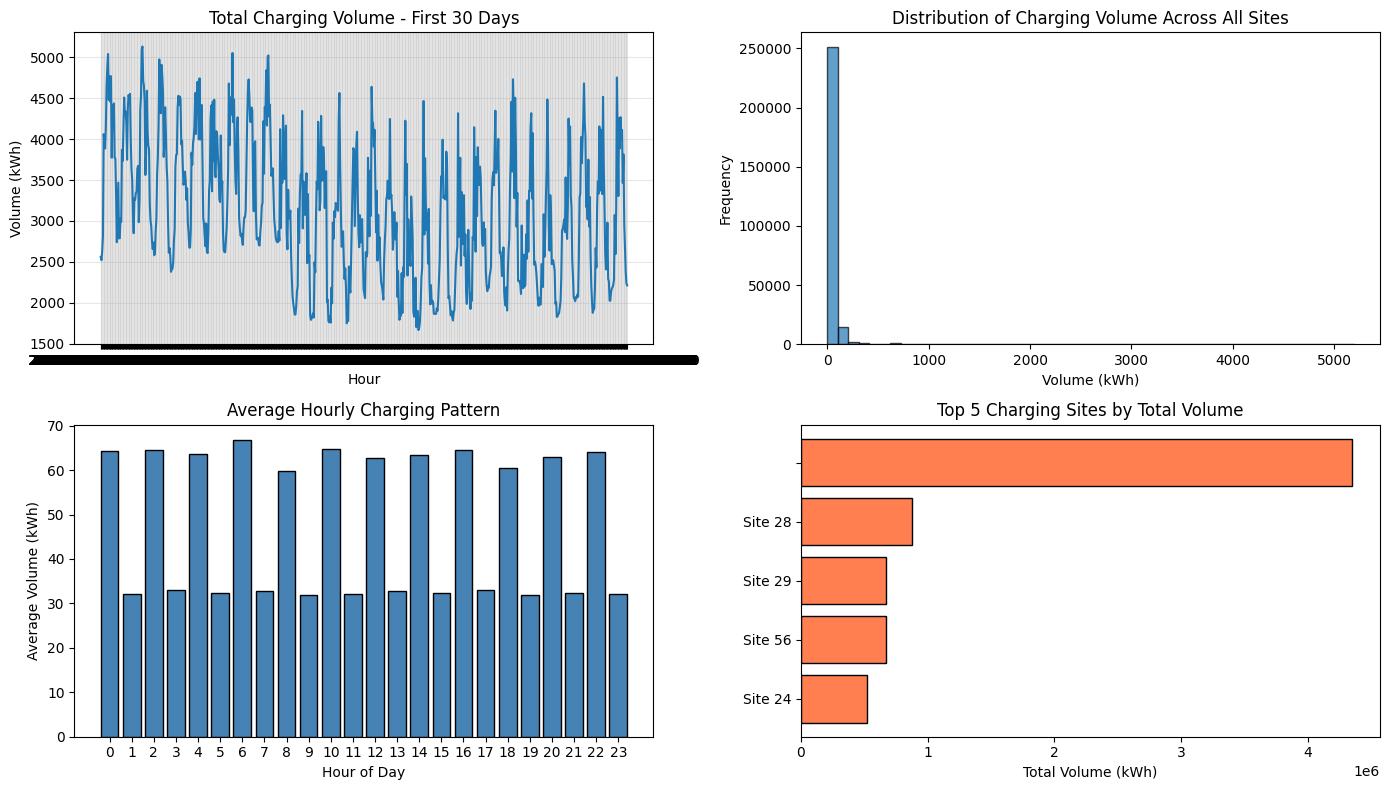


✓ Melbourne charging demand visualization complete!


In [3]:
# Calculate statistics from volume_df
total_volume = volume_df.sum(axis=1)      # Total across all sites per hour
avg_volume = volume_df.mean(axis=1)       # Average per site per hour
max_volume = volume_df.max(axis=1)        # Max per hour

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time series of total volume
axes[0, 0].plot(total_volume[:720])  # First 30 days
axes[0, 0].set_title('Total Charging Volume - First 30 Days')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Volume (kWh)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(volume_df.values.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Charging Volume Across All Sites')
axes[0, 1].set_xlabel('Volume (kWh)')
axes[0, 1].set_ylabel('Frequency')

# Hourly pattern (average across all data)
hourly_pattern = volume_df.values.reshape(-1, 24).mean(axis=0)
axes[1, 0].bar(range(24), hourly_pattern, color='steelblue', edgecolor='black')
axes[1, 0].set_title('Average Hourly Charging Pattern')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Volume (kWh)')
axes[1, 0].set_xticks(range(24))

# Site comparison (top 5 sites)
site_totals = volume_df.sum(axis=0)
top_5_sites = site_totals.argsort()[-5:]
axes[1, 1].barh(range(5), site_totals.iloc[top_5_sites].values, color='coral', edgecolor='black')
axes[1, 1].set_title('Top 5 Charging Sites by Total Volume')
axes[1, 1].set_xlabel('Total Volume (kWh)')
axes[1, 1].set_yticklabels([f'Site {i}' for i in top_5_sites])

plt.tight_layout()
plt.show()

print("\n✓ Melbourne charging demand visualization complete!")

In [4]:
# Map visualization of top charging sites
import folium
from folium import plugins

# Get top 10 sites by volume
top_10_sites = site_totals.argsort()[-10:]
top_10_data = sites_df.loc[top_10_sites].copy()
top_10_data['volume'] = site_totals.iloc[top_10_sites].values

# Calculate center of map
center_lat = top_10_data['latitude'].mean()
center_lon = top_10_data['longitude'].mean()

# Create map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=12,
    tiles='OpenStreetMap'
)

# Add markers for top 10 sites
colors = ['red', 'darkred', 'orange', 'beige', 'green', 'darkgreen', 'blue', 'darkblue', 'purple', 'darkpurple']

for idx, (site_id, row) in enumerate(top_10_data.iterrows()):
    # Size based on volume
    volume = row['volume']
    radius = 15 + (volume / top_10_data['volume'].max()) * 20
    
    # Create popup with site info
    popup_text = f"""
    <b>Site {site_id}</b><br>
    Total Volume: {volume:,.0f} kWh<br>
    Chargers: {row['charger_num']:.0f}<br>
    Avg Power: {row['avg_power']:.2f} kW<br>
    Coords: ({row['latitude']:.4f}, {row['longitude']:.4f})
    """
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        popup=folium.Popup(popup_text, max_width=300),
        color=colors[idx],
        fill=True,
        fillColor=colors[idx],
        fillOpacity=0.7,
        weight=2,
        tooltip=f"Site {site_id}: {volume:,.0f} kWh"
    ).add_to(m)

# Add title
title_html = '''
             <div style="position: fixed; 
                     top: 10px; left: 50px; width: 350px; height: auto; 
                     background-color: white; border:2px solid grey; z-index:9999; 
                     font-size:16px; font-weight: bold; padding: 10px">
             Top 10 EV Charging Sites in Melbourne
             </div>
             '''
m.get_root().html.add_child(folium.Element(title_html))

print("✓ Map created successfully!")
print(f"Top 10 sites plotted in Melbourne")
print(f"Center coordinates: ({center_lat:.4f}, {center_lon:.4f})")
m

✓ Map created successfully!
Top 10 sites plotted in Melbourne
Center coordinates: (-37.8187, 145.0472)


In [5]:
output_file = "melbourne_charging_map.html"
m.save(output_file)